# SST-2 Dataset Processing and Length-Based EDA

**Overview**

This notebook demonstrates two major steps in preparing and analyzing the SST-2 dataset:

    1.Length-based data splitting
    We create short (bottom 30%) and long (top 30%) subsets based on sentence word counts for all splits (train, val, internal_val).

    2.Exploratory Data Analysis (EDA)
    We examine dataset sizes, sentence length distributions, and compare the characteristics of different splits and subsets.

**Motivation**

Sentence length is known to influence model behavior and robustness in text classification tasks.
Long sentences often contain more complex syntactic structures, multiple clauses, and discourse markers, making them harder for models to interpret.
Short sentences, on the other hand, tend to be emotionally polarized and easier to classify.

To systematically evaluate model performance across different length ranges, we explicitly construct long/short subsets and analyze their statistical properties.

## Short/Long Subset Construction

In [ ]:
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
root = Path("../data/processed")
save_root = Path("../data/processed_length_splits")
save_root.mkdir(parents=True, exist_ok=True)

In [ ]:
files = {
    "train": root / "sst2_train.pkl",
    "val": root / "sst2_val.pkl",
    "test": root / "sst2_test.pkl",
}


In [ ]:
def load_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_pkl(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)


def extract_short_long(data, ratio=0.30):
    lengths = np.array(data["word_counts"])  
    N = len(lengths)
    k = int(N * ratio)

    sorted_idx = np.argsort(lengths)
    short_idx = sorted_idx[:k]
    long_idx = sorted_idx[-k:]

    keys = list(data.keys())

    def subset(indices):
        new_data = {}
        for k in keys:
            v = data[k]
            if isinstance(v, list):
                new_data[k] = [v[i] for i in indices]
            else:
                new_data[k] = v             
        return new_data

    return subset(short_idx), subset(long_idx)

In [ ]:
for split, path in files.items():
    print(f"Processing {split} ...")
    data = load_pkl(path)

    short_subset, long_subset = extract_short_long(data, ratio=0.10)

    save_pkl(short_subset, save_root / f"sst2_{split}_short.pkl")
    save_pkl(long_subset, save_root / f"sst2_{split}_long.pkl")

print("\nDone! All subsets saved to:", save_root)


Processing train ...
Processing val ...
Processing test ...

Done! All subsets saved to: ..\data\processed_length_splits


## EDA

=== Subset Sizes ===
sst2_test_long.pkl             size = 682
sst2_test_short.pkl            size = 682
sst2_train_long.pkl            size = 5457
sst2_train_short.pkl           size = 5457
sst2_val_long.pkl              size = 682
sst2_val_short.pkl             size = 682


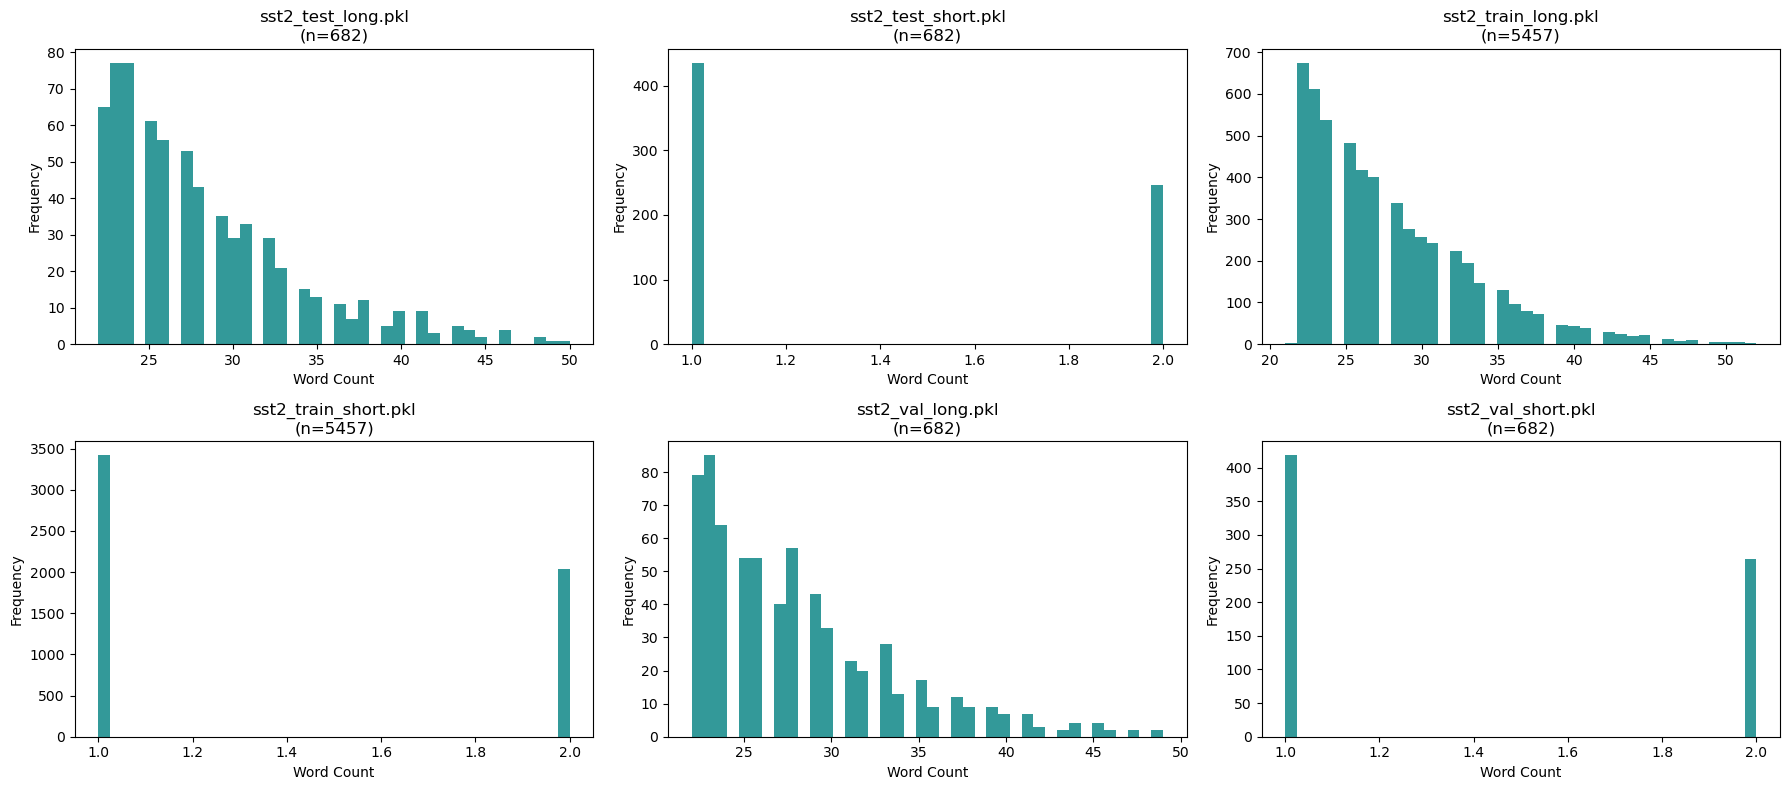

In [4]:
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ====== load subset directory ======
root_splits = Path("../data/processed_length_splits")
files_splits = sorted(list(root_splits.glob("*.pkl")))  # all short/long subsets

def load_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# ====== Inspect sizes ======

print("=== Subset Sizes ===")
subset_sizes = {}

for path in files_splits:
    data = load_pkl(path)
    size = len(data["texts"])
    subset_sizes[path.name] = size
    print(f"{path.name:<30} size = {size}")

# ====== EDA: histograms for each subset ======

num_files = len(files_splits)
cols = 3
rows = int(np.ceil(num_files / cols))

plt.figure(figsize=(18, 4 * rows))

for i, path in enumerate(files_splits):
    data = load_pkl(path)
    lengths = data["word_counts"]

    plt.subplot(rows, cols, i+1)
    plt.hist(lengths, bins=40, color="teal", alpha=0.8)
    plt.title(f"{path.name}\n(n={len(lengths)})")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()